In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt


In [5]:
# load the data
foldername = '/Users/emily/Downloads/'
filename = '2020_08_01_18_10_16_589437_compressed_Day_spine.npy'
fullfilename = os.path.join(foldername, filename)
data = np.load(fullfilename)
# inspect the data
print(data.shape)
print(data.dtype)

(28802, 6, 2)
float64


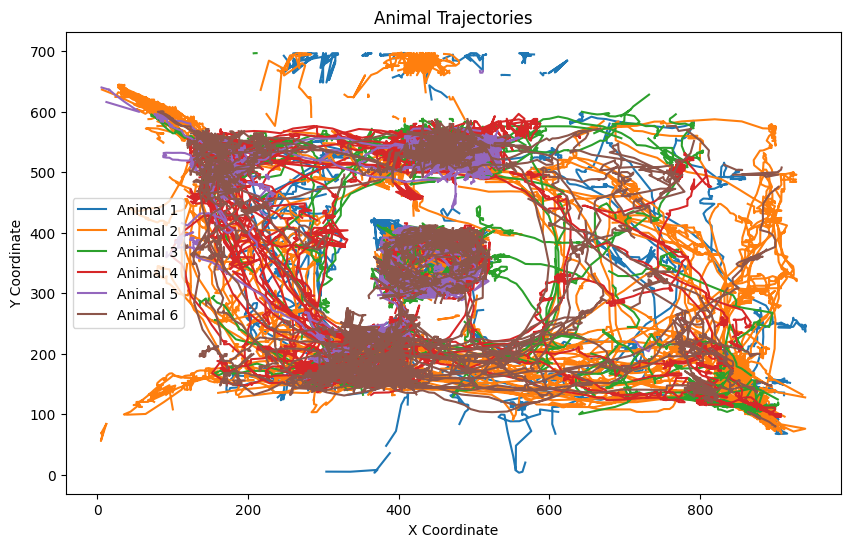

In [6]:
# plot the data
# the dimensions of the data are (time, animal_num, XY)

#  data shape is (time, animal_num, XY)

time, animal_num, _ = data.shape

# Create a plot for each animal's trajectory
plt.figure(figsize=(10, 6))
for i in range(animal_num):
    # Extract the X and Y coordinates for the current animal
    x_coords = data[:, i, 0]
    y_coords = data[:, i, 1]
    
    # Plot the trajectory
    plt.plot(x_coords, y_coords, label=f'Animal {i+1}')

# Add labels and a legend
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Animal Trajectories')
plt.legend()

# Show the plot
plt.show()

